In [13]:
import corner
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
!pip install emcee


from importlib.machinery import SourceFileLoader

from astropy.io import fits
from astropy import table
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.coordinates as coord

from collections import Counter
from astropy.io import ascii

#plt.style.use('/Users/apace/.matplotlib/stylelib/std.mplstyle')

In [14]:
## this loads the mcmc code
mcmc_temp = SourceFileLoader("mcmc", "/Users/ishika/Desktop/College Shiz/Research 2024/mcmc_wrapper.py").load_module()

In [3]:
## this loads the data from github so you will need internet connection

## this loads a file that has summary information about  Milky Way dwarf galaxies
## the most important thing we want is ra0, dec0 (center of system) and vlos_mean (systemic velocity of system)
## the rest is other summary information about each dwarf 
dwarf_info_all = table.Table.read('https://raw.githubusercontent.com/apace7/local_volume_database/main/data/dwarf_mw.csv')
## this picks out information about tucana_3 the system we are studying here
dwarf_info = dwarf_info_all[dwarf_info_all['key']=='tucana_3'][0]
ra0, dec0 = float(dwarf_info['ra']), float(dwarf_info['dec'])
rh, rh_e = float(dwarf_info['rhalf']), float((dwarf_info['rhalf_em']+dwarf_info['rhalf_ep'])/2.)
pa, pa_e = float(dwarf_info['position_angle']),float((dwarf_info['position_angle_em']+dwarf_info['position_angle_ep'])/2.)
ell, ell_e = float(dwarf_info['ellipticity']), float((dwarf_info['ellipticity_em']+dwarf_info['ellipticity_ep'])/2.)
dm0 =  float(dwarf_info['distance_modulus'])
dist = float(dwarf_info['distance'])
vlos_mean, vlos_mean_error = float(dwarf_info['vlos_systemic']), float((dwarf_info['vlos_systemic_em']+dwarf_info['vlos_systemic_ep'])/2.)
# vgsr_mean = float(apy.cal_vgsr(ra0,dec0, vlos_mean))
print(vlos_mean, )
pmra_mean, pmdec_mean, pmra_error, pmdec_error =  dwarf_info['pmra'], dwarf_info['pmdec'],float((dwarf_info['pmra_em']+dwarf_info['pmra_ep'])/2.), float((dwarf_info['pmdec_em']+dwarf_info['pmdec_ep'])/2.)
print(rh, ra0, dec0)
sigma_vlos = dwarf_info['vlos_sigma']
print(sigma_vlos)
feh_mean, feh_mean_error = dwarf_info['metallicity'], float((dwarf_info['metallicity_em']+dwarf_info['metallicity_ep'])/2.)
feh_sigma = 0.42 #dwarf_info['metallicity_sigma']
print(feh_mean, feh_sigma, feh_mean_error)
pm_sigma = 12./4.74/dist
print(pm_sigma)
parallax_mean = np.power(10,-(dm0+5)/5)*1000
parallax_mean_error = 0.0002
print(parallax_mean, parallax_mean_error)
logg_error=0.5

-102.3
5.1 359.1075 -59.58332
--
-2.42 0.42 0.07500000000000001
0.11051033727599129
0.04365158322401656 0.0002


In [4]:
##columns: ID, (heliocentric) velocity , velocity error, ra (deg), dec (deg) (ICRS frame), member (this is all members)
tuc3_data = table.Table(np.load('/Users/ishika/Desktop/College Shiz/Research 2024/tucana_3.npy'))
tuc3_data.dtype

dtype([('DES_id', '<U19'), ('vlos', '<f8'), ('vlos_error', '<f8'), ('ra', '<f8'), ('dec', '<f8'), ('member', '<f8')])

In [5]:
## there are two models applied here
## one does not apply the velocity gradient and the other has the velocity gradient
## the initial model is for comparison purposes

In [6]:
import os
## prior limits for the model
## vlos minimum/maximum (systemic velocity of system)
## sigma minimum/maximum (velocity dispersion of system), this is in logarithmic space (10**-2 - 10**1.7 or 0.01 to ~50 in linear space) 
## the units of both are km/s
#this defines the limits (parameter space) for the MCMC simulation
#setting the minimum and maximum for the systemic velocity
limits = [float(np.min(tuc3_data['vlos']))-20, float(np.max(tuc3_data['vlos']))+20, -2, 1.7]

## this calls a function that does the modeling
## this only takes in the velocity and error as include
out_vlos = mcmc_temp.mcmc(tuc3_data['vlos'],tuc3_data['vlos_error'], limits=limits, progress=True)

## other parameter that might matter (nsteps, ), number of steps in mcmc

## this takes the output and flattens it so we can plot it
#retrieves the MCMC sample 
samples_vlos_sigma = out_vlos.get_chain(discard=1000, thin=10, flat=True)
os.makedirs('results_v4', exist_ok=True)
np.save('results_v4/samples_vlos_sigma.npy', samples_vlos_sigma)
# np.save('results_v4/kgo2_feh_mcmc_v1.npy',flat_samples )

100%|██████████████████████████████████████| 5000/5000 [00:08<00:00, 593.50it/s]


vlos: median = -102.24, 16th = -102.55, 84th = -101.93
log10sigma: median = -0.27, 16th = -1.30, 84th = 0.03


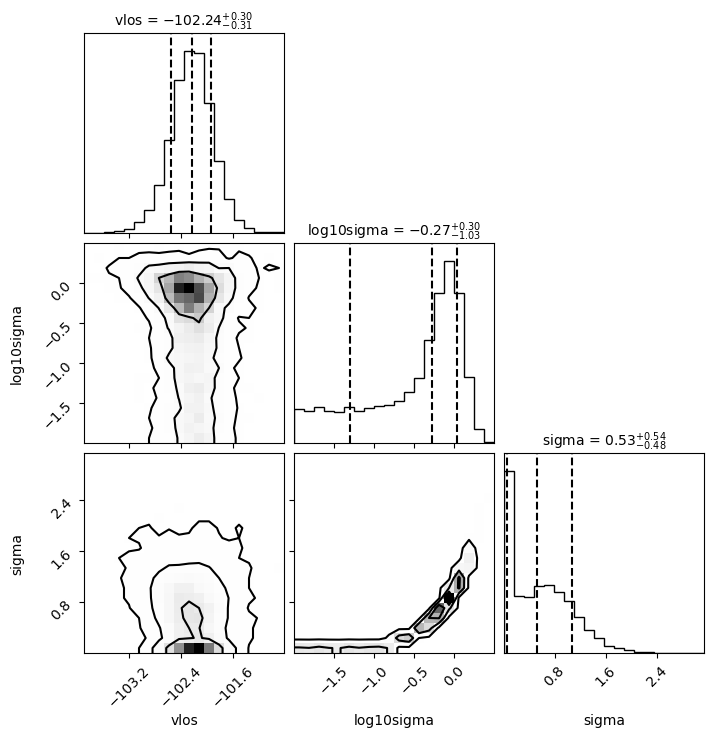

In [7]:
## plot of the data
## vlos = systemic velocity
## sigma = velocity dispersion, I have plotted this parameter in log10 and linear space 
## this is a corner plot, it is the distribution of model parameters.  You can see correlations between the parameters with this model
#free parameters that are being estimated by the data 
temp = np.array([[kk[0], kk[1],np.power(10.,kk[1])] for kk in samples_vlos_sigma ])
corn = corner.corner(temp,quantiles=[0.16, 0.50, 0.84], 
                           show_titles=True, title_kwargs={"fontsize": 10},
                           plot_datapoints = False,bins=[20]*len(temp.T),levels=[ 0.393469, 0.864665, 0.988891],
                           labels=['vlos','log10sigma','sigma'])


quantiles = np.quantile(samples_vlos_sigma, [0.16, 0.5, 0.84], axis=0)
medians = quantiles[1]  # 50th percentile (median)
lower_bound = quantiles[0]  # 16th percentile
upper_bound = quantiles[2]  # 84th percentile
n=2

# Optionally, print or store the results
for param_name, median, lower, upper in zip(['vlos', 'log10sigma', 'sigma'], medians, lower_bound, upper_bound):
    median = "{:0.{prec}f}".format(median, prec=n)
    lower = "{:0.{prec}f}".format(lower, prec=n)
    upper = "{:0.{prec}f}".format(upper, prec=n)
    print(f"{param_name}: median = {median}, 16th = {lower}, 84th = {upper}")

# plt.savefig('plots/uma3_mcmc_all_stars.pdf')
plt.show()

In [8]:
## this converts from the observed frame (ra, dec) to the x,y plane
## the second output is in a rotated frame (xr,yr)
## the rotation (angle rotate) here is in the common astronomy frame ( North to East ), 1 = axis ratio, don't change
## the dist parameter doesn't need to be changed, but with the input, the output units are in arcmin
def coord_change(ra, dec, r,d, dist=180./np.pi*60., rotate=90, q=1.):
    ra = np.array(ra)
    dec = np.array(dec)
    a = np.pi/180.
    x =  dist*np.cos(a * dec)* np.sin(a*(ra - r))
    y = dist*(np.sin(a*dec) *np.cos(a*d) - np.cos(a*dec)*np.sin(a*d) * np.cos(a*(ra - r)))
    angle = (90.-rotate)*np.pi/180.
    xr = x*np.cos(angle) + y*np.sin(angle)
    yr = -x*np.sin(angle) + y*np.cos(angle)

    return x,y, np.sqrt(x**2 + y**2), xr, yr, np.sqrt(xr**2 + yr**2/q**2)

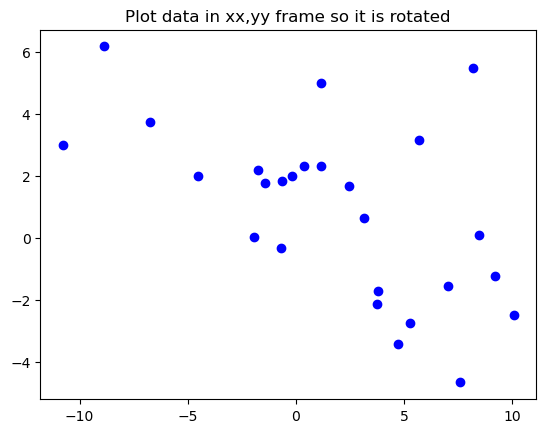

In [9]:
temp = coord_change(tuc3_data['ra'], tuc3_data['dec'], ra0, dec0)
tuc3_data['xx']=temp[0]
tuc3_data['yy']=temp[1]
plt.scatter(tuc3_data['xx'], tuc3_data['yy'], c='blue', marker='o')
plt.title('Plot data in xx,yy frame so it is rotated')
plt.show()
## plot the data in the xx,yy frame so that it can be rotated 
# DO THAT I GUESS??


In [10]:
## the limits for the mcmc
## the first two (or 4 parameters) terms are the same as before
## the next two are the velocity gradient amplitude (0, 100), the units of this are km/s / arcmin (the units that the xx,yy are in)
## the last two parameters are the min/max of the velocity gradient angle (in radians here)
#the velocity gradient is what we are interested in for the galaxies 
limits = [float(np.min(tuc3_data['vlos']))-20, float(np.max(tuc3_data['vlos']))+20, -2, 1.7, 0, 100, -np.pi, np.pi]

## this calls a different function and takes the xx,yy as input
out_vlos = mcmc_temp.mcmc_grad(tuc3_data['vlos'],tuc3_data['vlos_error'], tuc3_data['xx'], tuc3_data['yy'], limits=limits, progress=True, nsteps=20000)

## 
samples_vlos_gradient = out_vlos.get_chain(discard=10000, thin=20, flat=True)
#np.save('results_v4/kgo2_feh_mcmc_v1.npy',flat_samples )
np.save('results_v4/samples_vlos_gradient.npy', samples_vlos_gradient)

100%|████████████████████████████████████| 20000/20000 [00:34<00:00, 578.57it/s]


vlos: median = -102.35, 16th = -102.69, 84th = -101.98
log10sigma: median = -0.58, 16th = -1.54, 84th = -0.03
vlos_dispersion: median = 0.13, 16th = 0.06, 84th = 0.23
vgrad: median = 1.59, 16th = 0.34, 84th = 2.70


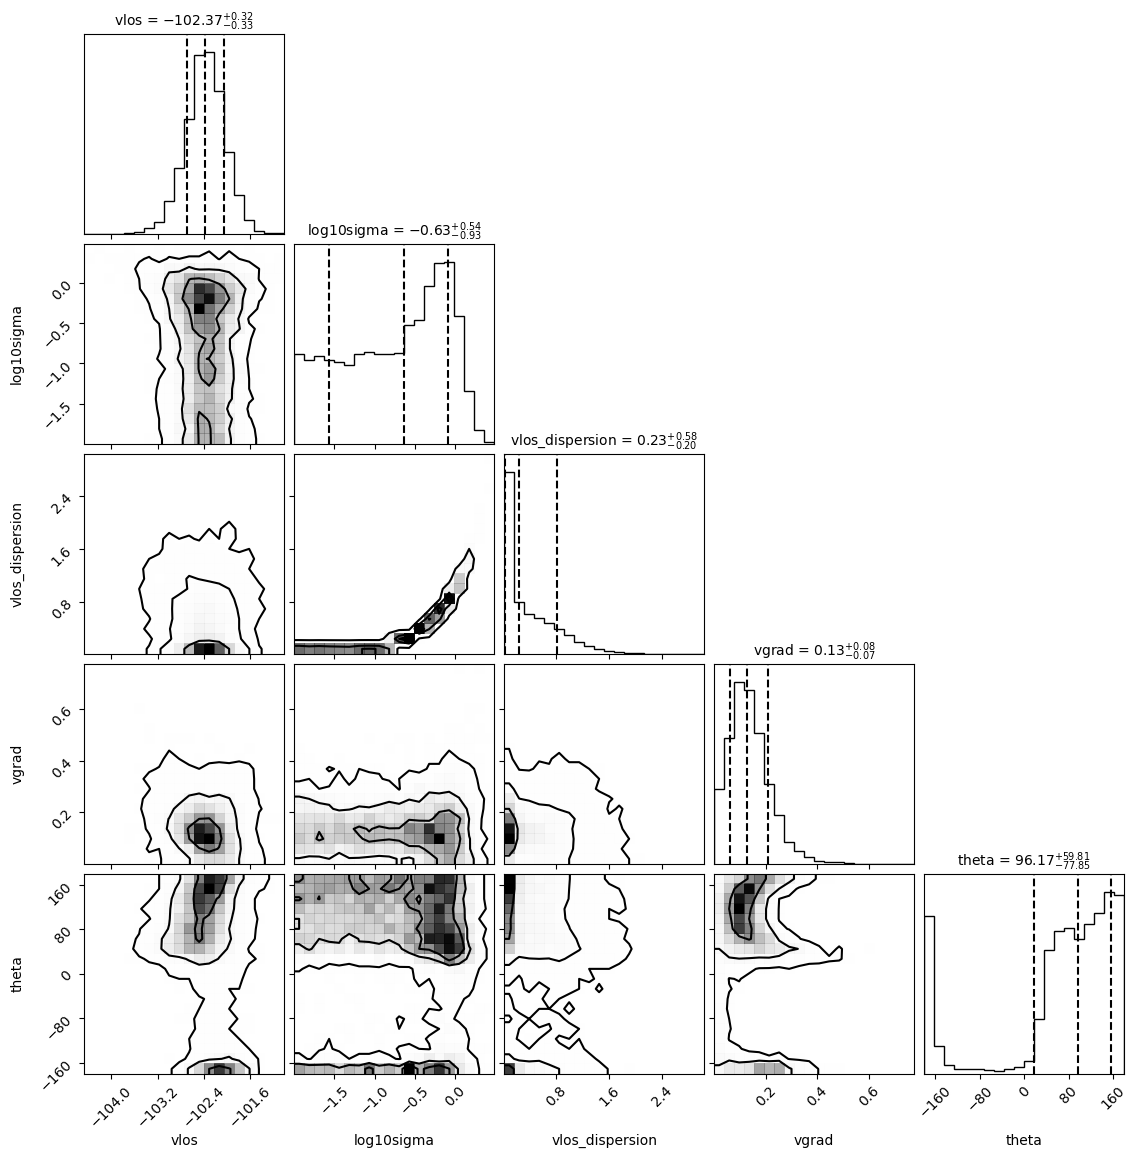

In [16]:
## plot thedata, the cut is to remove part of the "chain" (in mcmc langauge) that has not converged
temp = np.array([[kk[0], kk[1],np.power(10.,kk[1]), kk[2], kk[3]*180./np.pi] for kk in samples_vlos_gradient if 10**kk[1]<20])
# if 10**kk[1]<20 and kk[2]<10
corn = corner.corner(temp,quantiles=[0.16, 0.50, 0.84], 
                           show_titles=True, title_kwargs={"fontsize": 10},
                           plot_datapoints = False,bins=[20]*len(temp.T),levels=[ 0.393469, 0.864665, 0.988891],
                           labels=['vlos','log10sigma','vlos_dispersion', 'vgrad', 'theta'])

quantiles = np.quantile(samples_vlos_gradient, [0.16, 0.5, 0.84], axis=0)
medians = quantiles[1]  # 50th percentile (median)
lower_bound = quantiles[0]  # 16th percentile
upper_bound = quantiles[2]  # 84th percentile
n=2

# Optionally, print or store the results
for param_name, median, lower, upper in zip(['vlos', 'log10sigma', 'vlos_dispersion','vgrad','theta'], medians, lower_bound, upper_bound):
    median = "{:0.{prec}f}".format(median, prec=n)
    lower = "{:0.{prec}f}".format(lower, prec=n)
    upper = "{:0.{prec}f}".format(upper, prec=n)
    print(f"{param_name}: median = {median}, 16th = {lower}, 84th = {upper}")


# plt.savefig('plots/uma3_mcmc_all_stars.pdf')
plt.show()

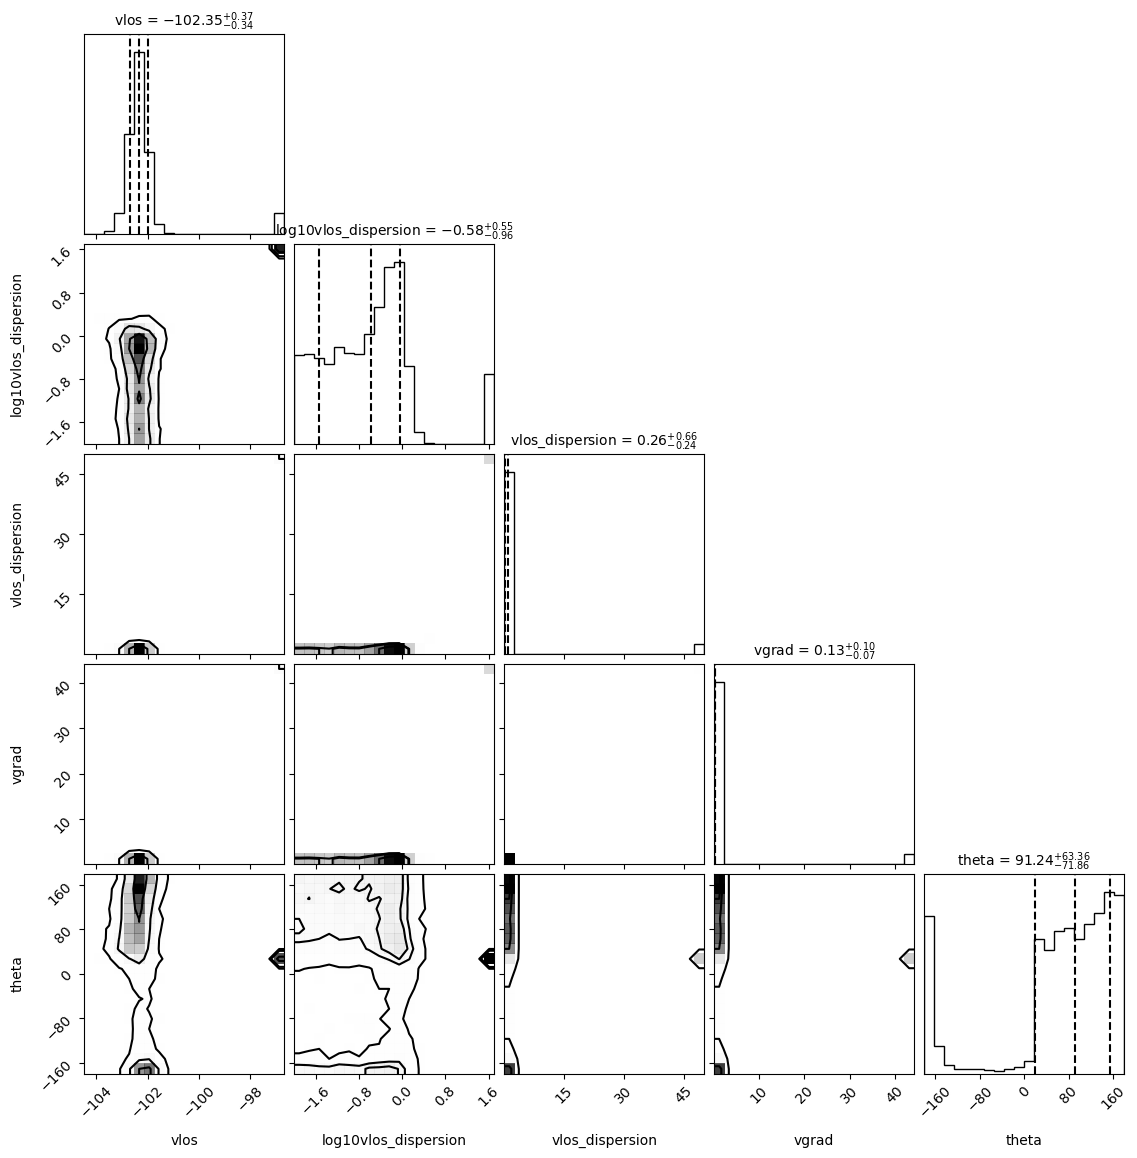

In [17]:
# flat_samples = np.load('results_v4/kgo2_vlos_mcmc_v1.npy', )
## similar plot (this was run longer for the chain to converge)
temp = np.array([[kk[0], kk[1],np.power(10.,kk[1]), kk[2], kk[3]*180./np.pi] for kk in samples_vlos_gradient ])
# if 10**kk[1]<20 and kk[2]<10
corn = corner.corner(temp,quantiles=[0.16, 0.50, 0.84], 
                           show_titles=True, title_kwargs={"fontsize": 10},
                           plot_datapoints = False,bins=[20]*len(temp.T),levels=[ 0.393469, 0.864665, 0.988891],
                           labels=['vlos','log10vlos_dispersion','vlos_dispersion', 'vgrad', 'theta'])
# plt.savefig('plots/uma3_mcmc_all_stars.pdf')
plt.show()